In [1]:
#! /app/software/R/4.0.3-foss-2020b/bin/Rscript
## JG used R/4.1.2-foss-2020b

# load external dependencies
lmod <- Sys.getenv("LMOD_CMD")
modules <- c(
    #"cairo/1.16.0-GCCcore-10.2.0",
    "R/4.1.2-foss-2020b",
    #"X11/20201008-GCCcore-10.2.0",
    "MACS2/2.2.6-foss-2019b-Python-3.7.4")

for (module in modules) {
    cmd <- paste(lmod, 'R', 'load', module)
    code <- system(cmd, intern = TRUE)
    eval(parse(text = code))
}

In [2]:
Sys.unsetenv("DISPLAY")

suppressPackageStartupMessages({
    library(ArchR)
    library(parallel)
    library(rtracklayer)
    library(repr)
    library(dplyr)
    library(Seurat)
    library(plyr)
    library(ComplexHeatmap)
    library(RColorBrewer)    
    library(BSgenome.Hsapiens.UCSC.hg38)
})
set.seed(1)

# Set default plot size
options(repr.plot.width=10, repr.plot.height=10)


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
           ___      .______        ______  __    __  .______      
          /   \     |   _ 

In [3]:
addArchRThreads(threads = 24)

Input threads is equal to or greater than ncores minus 1 (23)
Setting cores to ncores minus 2. Set force = TRUE to set above this number!

Setting default number of Parallel threads to 22.



In [4]:
#Utility functions
# SVD, UMAP, and Clustering
UMAP_clusters = function(proj){
    #SVD
    proj <- addIterativeLSI(
        ArchRProj = proj,
        useMatrix = "TileMatrix", 
        name = "IterativeLSI", 
        iterations = 2, 
        dimsToUse = 1:15, 
        varFeatures = 200000, 
        clusterParams = list( #See Seurat::FindClusters,
            resolution = c(0.1, 0.3), 
            sampleCells = 8000, 
            n.start = 10), 
        outlierQuantiles = c(0.025, 0.975), 
        verbose = FALSE,
        force=TRUE
    )
    #UMAP
    proj <- addUMAP(
        ArchRProj = proj,
        reducedDims = "IterativeLSI",
        name = "UMAP",
        nNeighbors = 40,
        minDist = 0.4,
        metric = "cosine",
        verbose = FALSE,
        force = TRUE
    )
    #Clustering
    proj <- addClusters(input = proj, 
                            method = "Seurat", 
                            name = "Clusters", 
                            reducedDims = "IterativeLSI",  
                            resolution = 0.1, 
                            #maxClusters = 100,
                            verbose = FALSE,
                            force=TRUE
                           )
    
    #Save
    #p1 <- plotEmbedding(ArchRProj = proj, colorBy = "cellColData", name = "Clusters", embedding = "UMAP")
    #plotPDF(p1, name = "Plot-UMAP-Sample-Clusters_1.pdf", ArchRProj = proj, addDOC = FALSE, width = 5, height = 5)
    return(proj)
}

In [5]:
#load data
proj_name = 'DJ_Hs_PBMC_K4me123_220523_220527_79x79_MERGE_50k'
version = 'proj_FINAL_v4'
proj_dir <- paste0("/fh/fast/henikoff_s/user/jgreene/projects/sciCnT/data/ArchR/", proj_name, '/', version)
proj = loadArchRProject(path = proj_dir,
                 force = TRUE,
                 showLogo = TRUE)
setwd(proj_dir)

Successfully loaded ArchRProject!


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
           ___      .______        ______  __    __  .____

In [9]:
plot_dir = '/fh/fast/henikoff_s/user/jgreene/projects/sciCnT/data/Figures/'

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-3fd61d8ae8f3-Date-2023-01-19_Time-13-33-03.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-3fd61d8ae8f3-Date-2023-01-19_Time-13-33-03.log



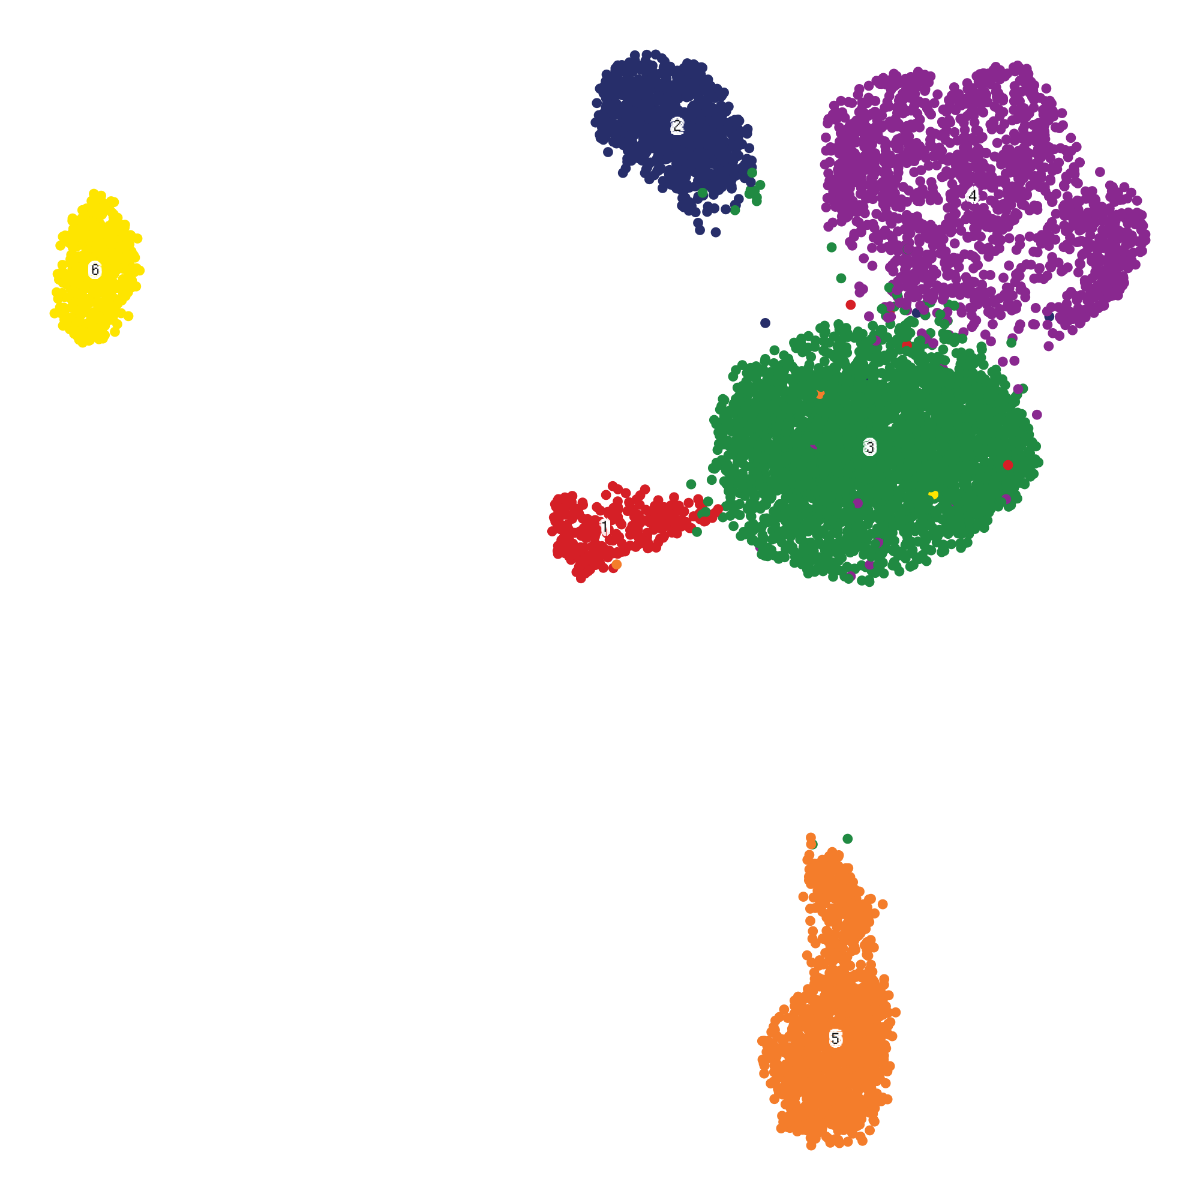

In [6]:
#Visualize clusters
plotEmbedding(ArchRProj = proj, colorBy = "cellColData", 
              name = "Clusters", 
              embedding = "UMAP", 
              size =1, 
              #pal= paletteContinuous(), 
              plotAs= "points", 
              #imputeWeights = getImputeWeights(proj)
             )+theme_void()+theme(plot.title = element_blank())+ NoLegend()

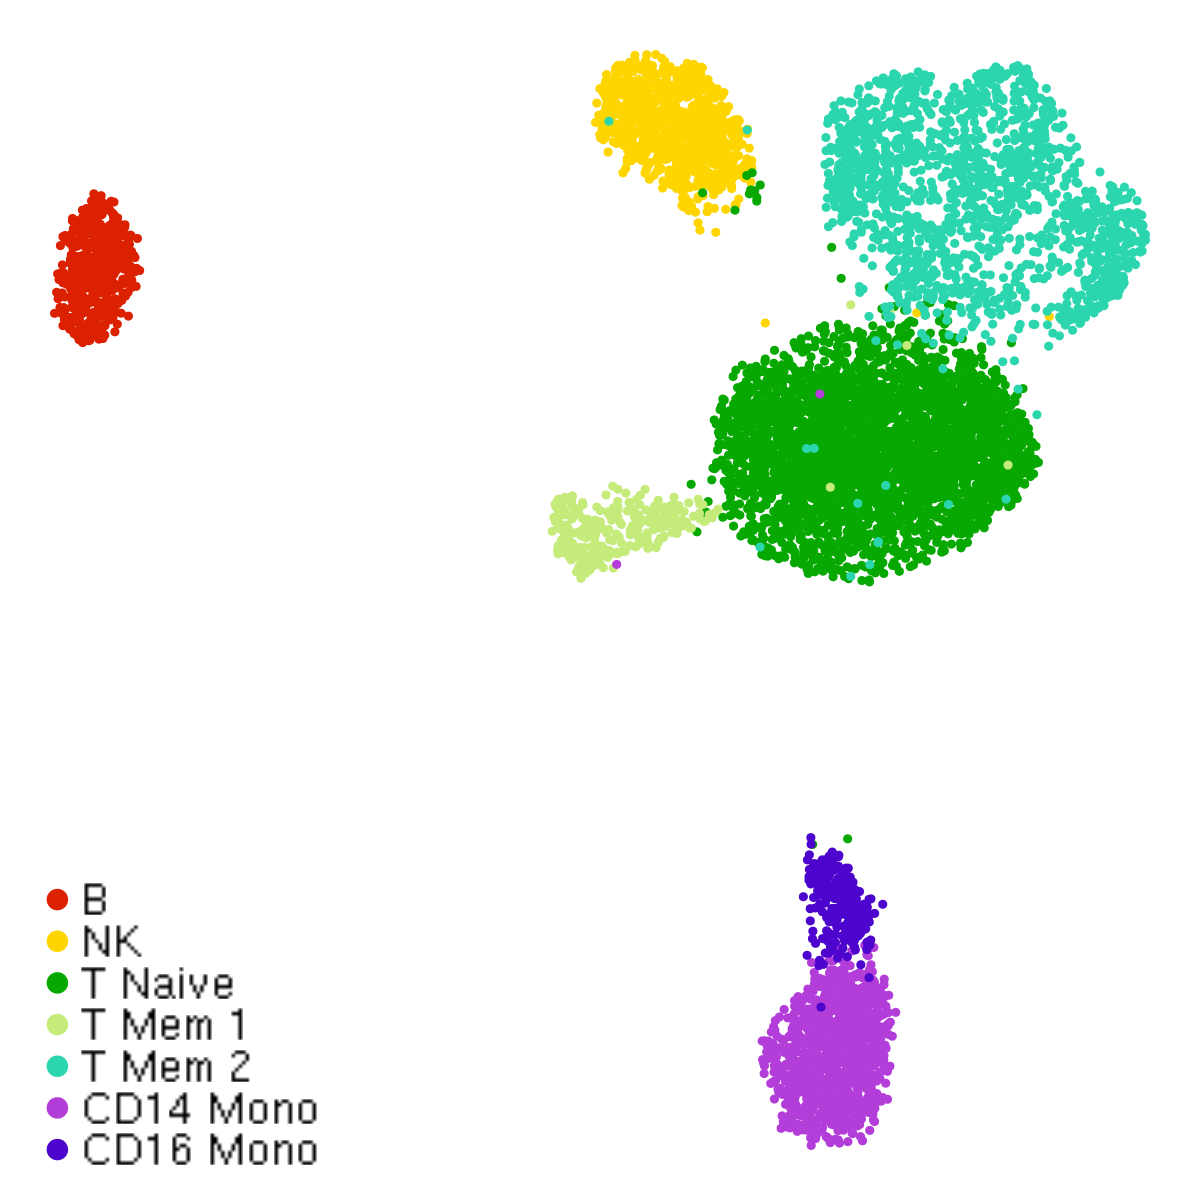

In [7]:
#extract umap
umap_df = proj@cellColData %>% data.frame()
umap_df$UMAP_1 = proj@embeddings$UMAP$df[,1]
umap_df$UMAP_2 = proj@embeddings$UMAP$df[,2]

#reorder and plot
ord_new = c( 'B','NK', 'T Naive', 'T Mem 1','T Mem 2', 'CD14 Mono', 'CD16 Mono')
umap_df$Clusters <- factor(umap_df$annotation, levels = ord_new)
umap_df <- umap_df[order(umap_df$Clusters),]


p0 = ggplot(umap_df, aes(x = UMAP_1, 
                    y = UMAP_2, 
                    color = Clusters)
    )+geom_point(position = "jitter"
    )+theme_void(
    )+theme(plot.title = element_blank(), 
            strip.text = element_blank(), 
            legend.position = c(.15, .15), 
            legend.text = element_text(size=25, family = 'Helvetica'),
            legend.title = element_blank()
    )+guides(color = guide_legend(override.aes = list(size = 5))
    )+scale_color_manual(name = "sciCUT&Tag \nCelltype Annotation",
                         values = c("#db2100", 
                                    "#ffd500",
                                    
                                    "#07a802",
                                    #"#139c90",
                                    
                                    "#c5eb7a", 
                                    "#2bd6ae",
                                     
                                    '#b23dd9',
                                    "#4d04cc")
)
p0

In [293]:
pdf(file=paste0(plot_dir, '221016_PBMC_K4me123_celltypes_no_title.pdf'),width=10, height=10)
p0
dev.off()

png 
  2

# Bulk K4me1 CnT projection

In [8]:
#load Altius CnT data
sum_dir = '/fh/fast/henikoff_s/user/jgreene/projects/sciCnT/data/Altius_Immunopedia/bams_K4/H3K4me1_altius_immunopedia_500_FINAL.RDS'
seCHIP = readRDS(sum_dir)
seCHIP

class: RangedSummarizedExperiment 
dim: 6176584 46 
metadata(0):
assays(1): counts
rownames: NULL
rowData names(0):
colnames(46): 31639.bam 31646.bam ... 44622.bam 44625.bam
colData names(250): id antibody ... local depth

In [9]:
table(colData(seCHIP)$taxonomy_name)


              h.CD14+             h.CD14+++          h.CD14+CD16+ 
                    2                     2                     2 
              h.CD16+         h.CD19.memory          h.CD19.naive 
                    2                     5                     6 
 h.CD4.memory.central h.CD4.memory.effector           h.CD4.naive 
                    3                     1                     2 
            h.CD4.Th1            h.CD4.Th17             h.CD4.Th2 
                    1                     3                     4 
           h.CD4.Treg         h.CD56.Bright            h.CD56.Dim 
                    2                     3                     5 
 h.CD8.memory.central           h.CD8.naive 
                    1                     2 

In [10]:
table(seCHIP@colData$antibody)


H3K4me1 (AM39297) H3K4me1 (AM39498) H3K4me1 (AM39635) 
               23                12                11 

In [11]:
projection<-projectBulkATAC(
  ArchRProj = proj,
  seATAC = seCHIP,
  reducedDims = "IterativeLSI",
  embedding = "UMAP",
  n = 500, 
  verbose = TRUE,
  threads = getArchRThreads(),
  logFile = createLogFile("projectBulkATAC")
)

ArchR logging to : ArchRLogs/ArchR-projectBulkATAC-3fd64f1db8a1-Date-2023-01-19_Time-13-34-11.log
If there is an issue, please report to github with logFile!

Overlap Ratio of Reduced Dims Features = 1

2023-01-19 13:34:19 : 

13:34:29 Creating temp directory /loc/scratch/7250413/RtmpXjikxy/dir3fd654feac8f

untar: using cmd = ‘/bin/tar -xf '/fh/fast/henikoff_s/user/jgreene/projects/sciCnT/data/ArchR/DJ_Hs_PBMC_K4me123_220523_220527_79x79_MERGE_50k/DJ_Hs_PBMC_K4me123_220523_220527_79x79_MERGE_50k/Embeddings/Save-Uwot-UMAP-Params-IterativeLSI-65e81d3fb2a3-Date-2022-10-16_Time-17-42-49.tar' -C '/loc/scratch/7250413/RtmpXjikxy/dir3fd654feac8f'’

13:34:31 Read 28000 rows
 and found 15 numeric columns

13:34:31 Processing block 1 of 1

13:34:31 Writing NN index file to temp file /loc/scratch/7250413/RtmpXjikxy/file3fd650e07bb1

13:34:31 Searching Annoy index using 11 threads, search_k = 4000

13:34:32 Commencing smooth kNN distance calibration using 11 threads
 with target n_neighbors = 40



In [278]:
### import meta
meta = read.csv('/fh/fast/henikoff_s/user/jgreene/projects/sciCnT/data/Altius_Immunopedia/bams_K4/K4_meta.csv')

p<-as.data.frame(do.call(rbind, projection[2:1]))
p$ds = data.frame(t(data.frame(strsplit(rownames(p), '#'))))$X1

unique(p$ds)
length(unique(p$ds))

[1] "DJ_Hs_PBMC_K4me123_ALLSEQ_220523_220527"
 [2] "31639.bam"                              
 [3] "31646.bam"                              
 [4] "31654.bam"                              
 [5] "31729.bam"                              
 [6] "35084.bam"                              
 [7] "35085.bam"                              
 [8] "35090.bam"                              
 [9] "35091.bam"                              
[10] "35096.bam"                              
[11] "35097.bam"                              
[12] "35108.bam"                              
[13] "35126.bam"                              
[14] "35127.bam"                              
[15] "35132.bam"                              
[16] "35133.bam"                              
[17] "35150.bam"                              
[18] "35151.bam"                              
[19] "35504.bam"                              
[20] "35509.bam"                              
[21] "35524.bam"                              
[22] "35525.bam"                              
[23] "35830.bam"                              
[24] "35897.bam"                              
[25] "37910.bam"                              
[26] "39081.bam"                              
[27] "39086.bam"                              
[28] "39442.bam"                              
[29] "39447.bam"                              
[30] "39451.bam"                              
[31] "39455.bam"                              
[32] "39460.bam"                              
[33] "39464.bam"                              
[34] "39469.bam"                              
[35] "39474.bam"                              
[36] "41078.bam"                              
[37] "41093.bam"                              
[38] "41103.bam"                              
[39] "41108.bam"                              
[40] "41111.bam"                              
[41] "41116.bam"                              
[42] "41121.bam"                              
[43] "41782.bam"                              
[44] "41786.bam"                              
[45] "42456.bam"                              
[46] "44622.bam"                              
[47] "44625.bam"

[1] 47

In [279]:
#map names to celltype

acc = meta$local[which(meta$local %in% p$ds)]
cel = meta$taxonomy_name[which(meta$local %in% p$ds)]
p$ds <- mapvalues(p$ds, from=acc, to=cel)
p = p[order(p$ds), ]
unique(p$ds)

[1] "DJ_Hs_PBMC_K4me123_ALLSEQ_220523_220527"
 [2] "h.CD14+"                                
 [3] "h.CD14+++"                              
 [4] "h.CD14+CD16+"                           
 [5] "h.CD16+"                                
 [6] "h.CD19.memory"                          
 [7] "h.CD19.naive"                           
 [8] "h.CD4.memory.central"                   
 [9] "h.CD4.memory.effector"                  
[10] "h.CD4.naive"                            
[11] "h.CD4.Th1"                              
[12] "h.CD4.Th17"                             
[13] "h.CD4.Th2"                              
[14] "h.CD4.Treg"                             
[15] "h.CD56.Bright"                          
[16] "h.CD56.Dim"                             
[17] "h.CD8.memory.central"                   
[18] "h.CD8.naive"

In [280]:
length(ann)

[1] 19

In [281]:
#rename celltypes
unq = unique(p$ds)

ann = c('sciCUT&Tag',
        
        'CD14+', 
        'CD14+++', 
        'CD14+CD16+', 
        'CD16+',   
        
        'CD19 Mem',
        'CD19 Naive', 
        
        #'CD3+', 
        
        'CD4 Mem.C',
        'CD4 Mem.E', 

        'CD4 Naive',
        'CD4 Th1', 
        'CD4 Th17',  
        'CD4 Th2', 
        'CD4 Treg',
        
      
        'CD56+++',  
        'CD56+',
        
        #'CD8 EMRA',
        'CD8 Mem.C',
        #'CD8 Mem.E',
        'CD8 Naive'  

        #'Neutrophil', 

        #'PBMC'
        )

p$ds <- mapvalues(p$ds, from=unq, to=ann)

In [282]:
#reorder
ord_new = c('sciCUT&Tag',
            
            'CD19 Naive', 
            'CD19 Mem', 

            'CD56+',
            'CD56+++', 
            
            #'CD3+',
            'CD4 Naive',
            'CD8 Naive',
            
            'CD4 Th1', 
            'CD4 Th2',            
            'CD4 Th17', 
            'CD4 Treg',
            
            'CD4 Mem.C',
            'CD4 Mem.E', 
            
            'CD8 Mem.C',
            #'CD8 Mem.E',
            #'CD8 EMRA',

            'CD14+',    
            'CD14+++', 
            'CD16+',
            'CD14+CD16+'            
            #'Neutrophil', 
            
            #'PBMC'             
            )
        
p$ds <- factor(p$ds, levels = ord_new)
p <- p[order(p$ds),]

#drop noisy data
p<-p[!(p$ds %in% c('PBMC',   'Neutrophil','CD3+','CD8 EMRA')),] # 'CD56+++', ','CD16+',

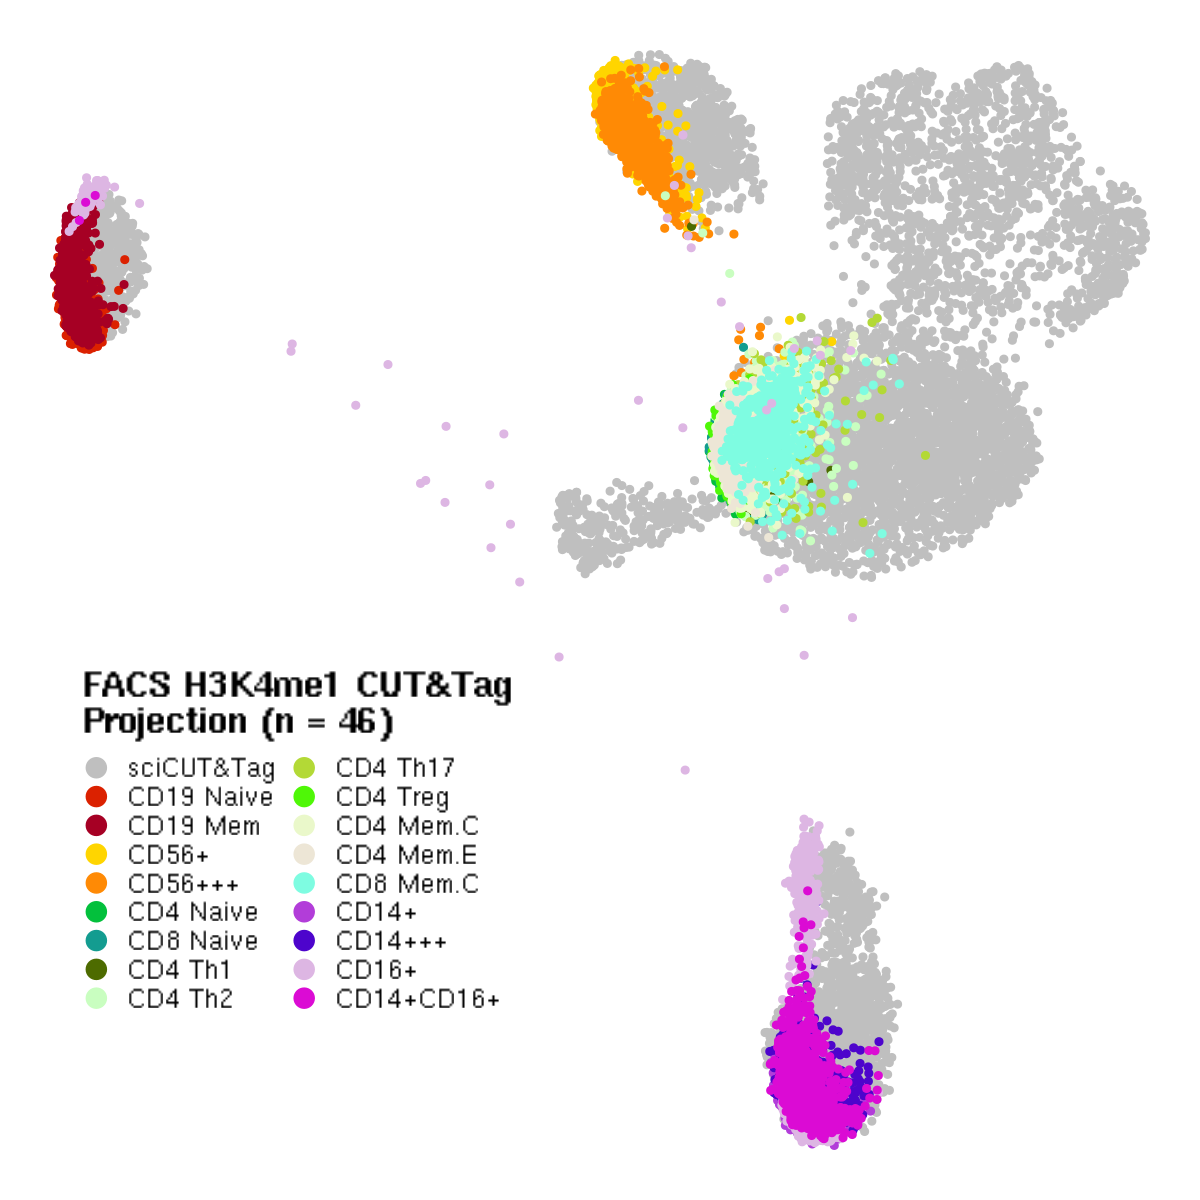

In [284]:
#plot
plot1 = ggplot(p, aes(x=UMAP1, 
              y=UMAP2, 
              color = ds))+geom_point(position = "jitter"
            )+theme_void(
      #      )+xlim(-9,15
      #      )+ylim(-8,8.5
            )+theme(#plot.title = element_blank(), 
            #strip.text = element_blank(), 
            legend.position = c(.25, .30), 
            legend.text = element_text(size=15, family = 'Helvetica'),
            legend.title = element_text(size=20, family = 'Helvetica', face = "bold")
    )+guides(color = guide_legend(override.aes = list(size = 5), ncol=2)
    )+scale_color_manual(name = 'FACS H3K4me1 CUT&Tag \nProjection (n = 46)',
                         values = c("gray75",
                                    #B
                                    "#db2100", 
                                    "#a60024",
                                    #NK
                                    "#ffd500",
                                    "#FF8A05",               
                                    #Naive T
                                    "#03C03C",
                                    "#139c90",
                                    #Treg
                                    '#4d6b00',
                                    '#c9fec0',
                                    "#B3D936",
                                    "#4ff707",
                                    #CD4 Mem
                                    '#EAF8CA',
                                    '#ede6d6',
                                    #CD8 Mem
                                    '#7efce1',
                                    #"#2bd6ae",
                                    #'#A5E3F7',
                                    #'#75CFEE',
                                    #'#2270C4',
                                    #Mono
                                    '#b23dd9',
                                    "#4d04cc",
                                    '#DDB6E3',
                                    "#db0bd4"
                                    #Other
                                    #'#111111',
                                    #'#000000'
                                   ))
plot1

In [285]:
#save
pdf(file=paste0(plot_dir, '221016_PBMC_K4me1_altius_projection.pdf'),width=10, height=10)
plot1
dev.off()

png 
  2

# Bulk K4me3 CnT projection

In [263]:
#load Altius CnT data
sum_dir = '/fh/fast/henikoff_s/user/jgreene/projects/sciCnT/data/Altius_Immunopedia/bams_K4/H3K4me3_altius_immunopedia_500_FINAL.RDS'
seCHIP = readRDS(sum_dir)
seCHIP

class: RangedSummarizedExperiment 
dim: 6176584 48 
metadata(0):
assays(1): counts
rownames: NULL
rowData names(0):
colnames(48): 31642.bam 31656.bam ... 44620.bam 44623.bam
colData names(250): id antibody ... local depth

In [264]:
#remove H3K4me3
seCHIP = subset(seCHIP, select = (colData(seCHIP)$antibody == 'H3K4me3 (CS9751)'))
seCHIP

class: RangedSummarizedExperiment 
dim: 6176584 48 
metadata(0):
assays(1): counts
rownames: NULL
rowData names(0):
colnames(48): 31642.bam 31656.bam ... 44620.bam 44623.bam
colData names(250): id antibody ... local depth

In [265]:
table(colData(seCHIP)$taxonomy_name)


              h.CD14+             h.CD14+++          h.CD14+CD16+ 
                    4                     3                     2 
              h.CD16+         h.CD19.memory          h.CD19.naive 
                    2                     4                     3 
 h.CD4.memory.central h.CD4.memory.effector           h.CD4.naive 
                    2                     4                     2 
            h.CD4.Th1            h.CD4.Th17             h.CD4.Th2 
                    2                     2                     3 
           h.CD4.Treg         h.CD56.Bright            h.CD56.Dim 
                    3                     2                     1 
 h.CD8.memory.central h.CD8.memory.effector           h.CD8.naive 
                    3                     2                     4 

In [266]:
table(seCHIP@colData$antibody)


H3K4me3 (CS9751) 
              48 

In [267]:
projection<-projectBulkATAC(
  ArchRProj = proj,
  seATAC = seCHIP,
  reducedDims = "IterativeLSI",
  embedding = "UMAP",
  n = 500, 
  verbose = TRUE,
  threads = getArchRThreads(),
  logFile = createLogFile("projectBulkATAC")
)

ArchR logging to : ArchRLogs/ArchR-projectBulkATAC-350e3fcf459f-Date-2022-10-17_Time-13-09-19.log
If there is an issue, please report to github with logFile!

Overlap Ratio of Reduced Dims Features = 1

2022-10-17 13:09:25 : 

13:10:07 Creating temp directory /loc/scratch/66622569/Rtmpn1G7AY/dir350e2667dbc0

untar: using cmd = ‘/bin/tar -xf '/fh/fast/henikoff_s/user/jgreene/projects/sciCnT/data/ArchR/DJ_Hs_PBMC_K4me123_220523_220527_79x79_MERGE_50k/DJ_Hs_PBMC_K4me123_220523_220527_79x79_MERGE_50k/Embeddings/Save-Uwot-UMAP-Params-IterativeLSI-65e81d3fb2a3-Date-2022-10-16_Time-17-42-49.tar' -C '/loc/scratch/66622569/Rtmpn1G7AY/dir350e2667dbc0'’

13:10:09 Read 29000 rows
 and found 15 numeric columns

13:10:09 Processing block 1 of 1

13:10:09 Writing NN index file to temp file /loc/scratch/66622569/Rtmpn1G7AY/file350e624c24d0

13:10:09 Searching Annoy index using 11 threads, search_k = 4000

13:10:10 Commencing smooth kNN distance calibration using 11 threads
 with target n_neighbors = 4

In [268]:
### import meta
meta = read.csv('/fh/fast/henikoff_s/user/jgreene/projects/sciCnT/data/Altius_Immunopedia/bams_K4/K4_meta.csv')

p<-as.data.frame(do.call(rbind, projection[2:1]))
p$ds = data.frame(t(data.frame(strsplit(rownames(p), '#'))))$X1

unique(p$ds)
length(unique(p$ds))

[1] "DJ_Hs_PBMC_K4me123_ALLSEQ_220523_220527"
 [2] "31642.bam"                              
 [3] "31656.bam"                              
 [4] "31732.bam"                              
 [5] "31739.bam"                              
 [6] "33560.bam"                              
 [7] "33565.bam"                              
 [8] "35093.bam"                              
 [9] "35105.bam"                              
[10] "35111.bam"                              
[11] "35123.bam"                              
[12] "35129.bam"                              
[13] "35135.bam"                              
[14] "35141.bam"                              
[15] "35147.bam"                              
[16] "35153.bam"                              
[17] "35506.bam"                              
[18] "35511.bam"                              
[19] "35516.bam"                              
[20] "35527.bam"                              
[21] "35533.bam"                              
[22] "35832.bam"                              
[23] "37893.bam"                              
[24] "37897.bam"                              
[25] "37900.bam"                              
[26] "37903.bam"                              
[27] "39079.bam"                              
[28] "39084.bam"                              
[29] "39441.bam"                              
[30] "39444.bam"                              
[31] "39449.bam"                              
[32] "39453.bam"                              
[33] "39458.bam"                              
[34] "39462.bam"                              
[35] "39578.bam"                              
[36] "41081.bam"                              
[37] "41086.bam"                              
[38] "41091.bam"                              
[39] "41096.bam"                              
[40] "41101.bam"                              
[41] "41106.bam"                              
[42] "41109.bam"                              
[43] "41114.bam"                              
[44] "41119.bam"                              
[45] "41780.bam"                              
[46] "41784.bam"                              
[47] "42454.bam"                              
[48] "44620.bam"                              
[49] "44623.bam"

[1] 49

In [269]:
#map names to celltype

acc = meta$local[which(meta$local %in% p$ds)]
cel = meta$taxonomy_name[which(meta$local %in% p$ds)]
p$ds <- mapvalues(p$ds, from=acc, to=cel)
p = p[order(p$ds), ]
unique(p$ds)

[1] "DJ_Hs_PBMC_K4me123_ALLSEQ_220523_220527"
 [2] "h.CD14+"                                
 [3] "h.CD14+++"                              
 [4] "h.CD14+CD16+"                           
 [5] "h.CD16+"                                
 [6] "h.CD19.memory"                          
 [7] "h.CD19.naive"                           
 [8] "h.CD4.memory.central"                   
 [9] "h.CD4.memory.effector"                  
[10] "h.CD4.naive"                            
[11] "h.CD4.Th1"                              
[12] "h.CD4.Th17"                             
[13] "h.CD4.Th2"                              
[14] "h.CD4.Treg"                             
[15] "h.CD56.Bright"                          
[16] "h.CD56.Dim"                             
[17] "h.CD8.memory.central"                   
[18] "h.CD8.memory.effector"                  
[19] "h.CD8.naive"

In [270]:
#rename celltypes
unq = unique(p$ds)

ann = c('sciCUT&Tag',
        
        'CD14+', 
        'CD14+++', 
        'CD14+CD16+', 
        'CD16+',   
        
        'CD19 Mem',
        'CD19 Naive', 
        
        #'CD3+', 
        
        'CD4 Mem.C',
        'CD4 Mem.E', 

        'CD4 Naive',
        'CD4 Th1', 
        'CD4 Th17',  
        'CD4 Th2', 
        'CD4 Treg',
        
      
        'CD56+++',  
        'CD56+',
        
        #'CD8 EMRA',
        'CD8 Mem.C',
        'CD8 Mem.E',
        'CD8 Naive'  

        #'Neutrophil', 

        #'PBMC'
        )

p$ds <- mapvalues(p$ds, from=unq, to=ann)

In [271]:
#reorder
ord_new = c('sciCUT&Tag',
            
            'CD19 Naive', 
            'CD19 Mem', 

            'CD56+',
            'CD56+++', 
            
            #'CD3+',
            'CD4 Naive',
            'CD8 Naive',
            
            'CD4 Th1', 
            'CD4 Th2',            
            'CD4 Th17', 
            'CD4 Treg',
            
            'CD4 Mem.C',
            'CD4 Mem.E', 
            
            'CD8 Mem.C',
            'CD8 Mem.E',
            #'CD8 EMRA',

            'CD14+',    
            'CD14+++', 
            'CD16+',
            'CD14+CD16+'            
            #'Neutrophil', 
            
            #'PBMC'             
            )
        
p$ds <- factor(p$ds, levels = ord_new)
p <- p[order(p$ds),]

#drop noisy data
#p<-p[!(p$ds %in% c('PBMC',   'Neutrophil','CD3+','CD8 EMRA')),] # 'CD56+++', ','CD16+',

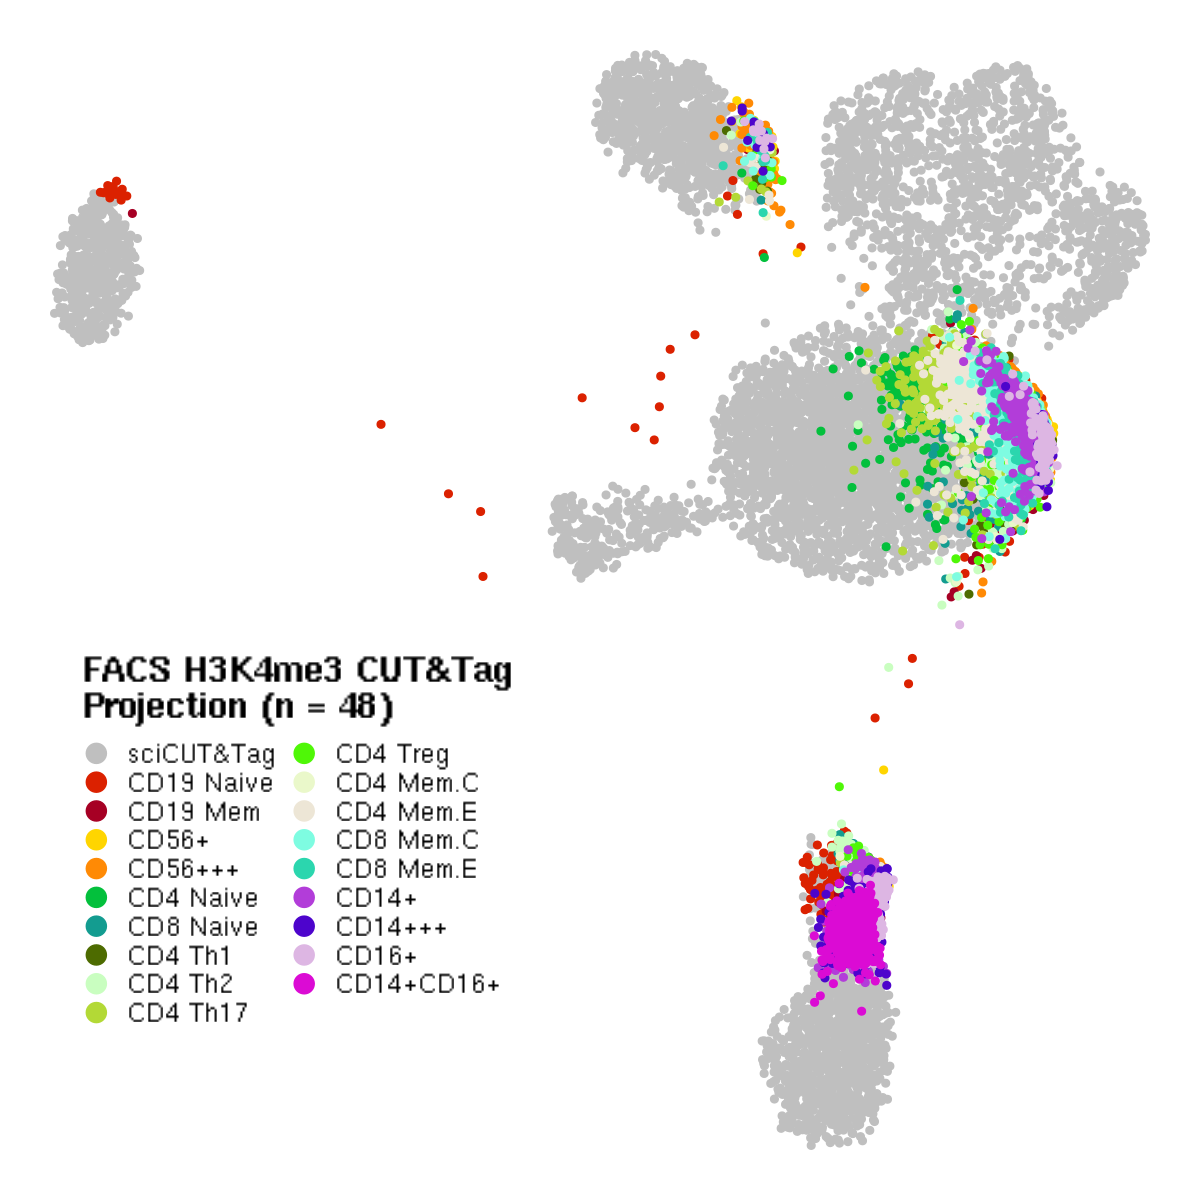

In [272]:
#plot
plot1 = ggplot(p, aes(x=UMAP1, 
              y=UMAP2, 
              color = ds))+geom_point(position = "jitter"
            )+theme_void(
       #     )+xlim(-9,15
       #     )+ylim(-8,8.5
            )+theme(#plot.title = element_blank(), 
            #strip.text = element_blank(), 
            legend.position = c(.25, .30), 
            legend.text = element_text(size=15, family = 'Helvetica'),
            legend.title = element_text(size=20, family = 'Helvetica', face = "bold")
    )+guides(color = guide_legend(override.aes = list(size = 5), ncol=2)
    )+scale_color_manual(name = 'FACS H3K4me3 CUT&Tag \nProjection (n = 48)',
                         values = c("gray75",
                                    #B
                                    "#db2100", 
                                    "#a60024",
                                    #NK
                                    "#ffd500",
                                    "#FF8A05",               
                                    #Naive T
                                    "#03C03C",
                                    "#139c90",
                                    #Treg
                                    '#4d6b00',
                                    '#c9fec0',
                                    "#B3D936",
                                    "#4ff707",
                                    #CD4 Mem
                                    '#EAF8CA',
                                    '#ede6d6',
                                    #CD8 Mem
                                    '#7efce1',
                                    "#2bd6ae",
                                    #'#A5E3F7',
                                    #'#75CFEE',
                                    #'#2270C4',
                                    #Mono
                                    '#b23dd9',
                                    "#4d04cc",
                                    '#DDB6E3',
                                    "#db0bd4"
                                    #Other
                                    #'#111111',
                                    #'#000000'
                                   ))
plot1

In [273]:
#save
pdf(file=paste0(plot_dir, '221016_PBMC_K4me3_altius_projection.pdf'),width=10, height=10)
plot1
dev.off()

png 
  2

In [73]:
a = subset(seCHIP, select = !(colData(seCHIP)$taxonomy_name %in% c('h.PBMC',   'h.neutrophil','h.CD3+','h.CD8.EMRA')))
a
saveRDS(a, file = "/fh/fast/henikoff_s/user/jgreene/projects/sciCnT/data/Altius_Immunopedia/bams_K4/H3K4me3_altius_immunopedia_500_FINAL.RDS")

class: RangedSummarizedExperiment 
dim: 6176584 48 
metadata(0):
assays(1): counts
rownames: NULL
rowData names(0):
colnames(48): 31642.bam 31656.bam ... 44620.bam 44623.bam
colData names(250): id antibody ... local depth

# H3K4me1 ChIP projection

In [242]:
#load ENCODE ChIP data
sum_dir = '/fh/fast/henikoff_s/user/jgreene/projects/sciCnT/data/Encode_Blood_K4me123_ChIP_v2/H3K4me123_encode_blood_500.RDS'
seCHIP = readRDS(sum_dir)
seCHIP

class: RangedSummarizedExperiment 
dim: 6176584 480 
metadata(0):
assays(1): counts
rownames: NULL
rowData names(0):
colnames(480): ENCFF722YKS.bam ENCFF796LSX.bam ... ENCFF241FBR.bam
  ENCFF115ZZA.bam
colData names(62): File.accession File.format ... paired depth

In [243]:
#remove unfiltered
table(colData(seCHIP)$Output.type)
seCHIP = subset(seCHIP, select = colData(seCHIP)$Output.type == 'alignments')
seCHIP


           alignments unfiltered alignments 
                  240                   240 

class: RangedSummarizedExperiment 
dim: 6176584 240 
metadata(0):
assays(1): counts
rownames: NULL
rowData names(0):
colnames(240): ENCFF796LSX.bam ENCFF932LFZ.bam ... ENCFF195XYW.bam
  ENCFF115ZZA.bam
colData names(62): File.accession File.format ... paired depth

In [244]:
#get only H3K4me1
table(colData(seCHIP)$Experiment.target)
seCHIP = subset(seCHIP, select = colData(seCHIP)$Experiment.target == 'H3K4me1-human')
seCHIP


H3K4me1-human H3K4me3-human 
          116           124 

class: RangedSummarizedExperiment 
dim: 6176584 116 
metadata(0):
assays(1): counts
rownames: NULL
rowData names(0):
colnames(116): ENCFF796LSX.bam ENCFF834FYW.bam ... ENCFF195XYW.bam
  ENCFF115ZZA.bam
colData names(62): File.accession File.format ... paired depth

In [245]:
table(colData(seCHIP)$Biosample.term.name)


                                                    activated B cell 
                                                                   1 
                    activated CD4-positive, alpha-beta memory T cell 
                                                                   1 
                           activated CD4-positive, alpha-beta T cell 
                                                                   2 
                           activated CD8-positive, alpha-beta T cell 
                                                                   1 
                     activated naive CD4-positive, alpha-beta T cell 
                                                                   2 
                     activated naive CD8-positive, alpha-beta T cell 
                                                                   3 
                                                    activated T-cell 
                                                                   6 
                   

In [246]:
projection<-projectBulkATAC(
  ArchRProj = proj,
  seATAC = seCHIP,
  reducedDims = "IterativeLSI",
  embedding = "UMAP",
  n = 500, 
  verbose = TRUE,
  threads = getArchRThreads(),
  logFile = createLogFile("projectBulkATAC")
)

ArchR logging to : ArchRLogs/ArchR-projectBulkATAC-350e393fa885-Date-2022-10-17_Time-12-45-24.log
If there is an issue, please report to github with logFile!

Overlap Ratio of Reduced Dims Features = 1

2022-10-17 12:45:36 : 

12:47:05 Creating temp directory /loc/scratch/66622569/Rtmpn1G7AY/dir350e6f8719c5

untar: using cmd = ‘/bin/tar -xf '/fh/fast/henikoff_s/user/jgreene/projects/sciCnT/data/ArchR/DJ_Hs_PBMC_K4me123_220523_220527_79x79_MERGE_50k/DJ_Hs_PBMC_K4me123_220523_220527_79x79_MERGE_50k/Embeddings/Save-Uwot-UMAP-Params-IterativeLSI-65e81d3fb2a3-Date-2022-10-16_Time-17-42-49.tar' -C '/loc/scratch/66622569/Rtmpn1G7AY/dir350e6f8719c5'’

12:47:07 Read 63000 rows
 and found 15 numeric columns

12:47:07 Processing block 1 of 1

12:47:07 Writing NN index file to temp file /loc/scratch/66622569/Rtmpn1G7AY/file350eda8c2

12:47:07 Searching Annoy index using 11 threads, search_k = 4000

12:47:10 Commencing smooth kNN distance calibration using 11 threads
 with target n_neighbors = 40



In [247]:
meta = read.csv('/fh/fast/henikoff_s/user/jgreene/projects/sciCnT/data/Encode_Blood_K4me123_ChIP_v2/K4_meta_FINAL.csv')

p<-as.data.frame(do.call(rbind, projection[2:1]))
p$ds = data.frame(t(data.frame(strsplit(rownames(p), '#'))))$X1

In [248]:
unique(p$ds)

[1] "DJ_Hs_PBMC_K4me123_ALLSEQ_220523_220527"
  [2] "ENCFF796LSX.bam"                        
  [3] "ENCFF834FYW.bam"                        
  [4] "ENCFF644RUN.bam"                        
  [5] "ENCFF006GGE.bam"                        
  [6] "ENCFF668OLF.bam"                        
  [7] "ENCFF209DCP.bam"                        
  [8] "ENCFF468BJB.bam"                        
  [9] "ENCFF602SRN.bam"                        
 [10] "ENCFF286SIJ.bam"                        
 [11] "ENCFF693NLG.bam"                        
 [12] "ENCFF974JYT.bam"                        
 [13] "ENCFF299RHK.bam"                        
 [14] "ENCFF068FLX.bam"                        
 [15] "ENCFF421LHS.bam"                        
 [16] "ENCFF600KQQ.bam"                        
 [17] "ENCFF194IWW.bam"                        
 [18] "ENCFF037LSU.bam"                        
 [19] "ENCFF849AZQ.bam"                        
 [20] "ENCFF485QTD.bam"                        
 [21] "ENCFF938XXJ.bam"                        
 [22] "ENCFF750WLK.bam"                        
 [23] "ENCFF832KOI.bam"                        
 [24] "ENCFF467BPV.bam"                        
 [25] "ENCFF454VBU.bam"                        
 [26] "ENCFF286AVT.bam"                        
 [27] "ENCFF191AVV.bam"                        
 [28] "ENCFF636YHQ.bam"                        
 [29] "ENCFF203EBS.bam"                        
 [30] "ENCFF170MSV.bam"                        
 [31] "ENCFF500JXT.bam"                        
 [32] "ENCFF917UYR.bam"                        
 [33] "ENCFF895CIB.bam"                        
 [34] "ENCFF084WTX.bam"                        
 [35] "ENCFF139ZWJ.bam"                        
 [36] "ENCFF935OPC.bam"                        
 [37] "ENCFF754IEG.bam"                        
 [38] "ENCFF451OXV.bam"                        
 [39] "ENCFF234XUU.bam"                        
 [40] "ENCFF769YSH.bam"                        
 [41] "ENCFF842SIO.bam"                        
 [42] "ENCFF179LXM.bam"                        
 [43] "ENCFF743COU.bam"                        
 [44] "ENCFF433ACX.bam"                        
 [45] "ENCFF438YTR.bam"                        
 [46] "ENCFF412NFB.bam"                        
 [47] "ENCFF806AXN.bam"                        
 [48] "ENCFF400OSZ.bam"                        
 [49] "ENCFF977PUR.bam"                        
 [50] "ENCFF454OLU.bam"                        
 [51] "ENCFF097LZB.bam"                        
 [52] "ENCFF015FUR.bam"                        
 [53] "ENCFF014NTW.bam"                        
 [54] "ENCFF826SBR.bam"                        
 [55] "ENCFF250VFC.bam"                        
 [56] "ENCFF251FLN.bam"                        
 [57] "ENCFF991CYG.bam"                        
 [58] "ENCFF204UAR.bam"                        
 [59] "ENCFF585VSC.bam"                        
 [60] "ENCFF888EQT.bam"                        
 [61] "ENCFF166FHS.bam"                        
 [62] "ENCFF441DFW.bam"                        
 [63] "ENCFF925XND.bam"                        
 [64] "ENCFF980VGM.bam"                        
 [65] "ENCFF631PTF.bam"                        
 [66] "ENCFF475XNC.bam"                        
 [67] "ENCFF611GUL.bam"                        
 [68] "ENCFF204XPH.bam"                        
 [69] "ENCFF145XXH.bam"                        
 [70] "ENCFF525WKG.bam"                        
 [71] "ENCFF407CFA.bam"                        
 [72] "ENCFF520NUM.bam"                        
 [73] "ENCFF881QWK.bam"                        
 [74] "ENCFF412HNQ.bam"                        
 [75] "ENCFF652UOE.bam"                        
 [76] "ENCFF971HCI.bam"                        
 [77] "ENCFF680WWR.bam"                        
 [78] "ENCFF625LEK.bam"                        
 [79] "ENCFF712LYF.bam"                        
 [80] "ENCFF253HNI.bam"                        
 [81] "ENCFF241FYT.bam"                        
 [82] "ENCFF150JKA.bam"                        
 [83] "ENCFF240BFH.bam"                        
 [84] "ENCFF469QDB

In [249]:
#map names to celltype
acc = meta$accession[which(meta$accession %in% p$ds)]
cel = meta$Biosample.term.name[which(meta$accession %in% p$ds)]
p$ds <- mapvalues(p$ds, from=acc, to=cel)
p = p[order(p$ds), ]

In [250]:
unique(p$ds)

[1] "activated B cell"                                                    
 [2] "activated CD4-positive, alpha-beta memory T cell"                    
 [3] "activated CD4-positive, alpha-beta T cell"                           
 [4] "activated CD8-positive, alpha-beta T cell"                           
 [5] "activated naive CD4-positive, alpha-beta T cell"                     
 [6] "activated naive CD8-positive, alpha-beta T cell"                     
 [7] "activated T-cell"                                                    
 [8] "activated T-helper 1 cell"                                           
 [9] "activated T-helper 17 cell"                                          
[10] "activated T-helper 2 cell"                                           
[11] "B cell"                                                              
[12] "CD14-positive monocyte"                                              
[13] "CD4-positive, alpha-beta memory T cell"                              
[14] "CD4-positive, alpha-beta T cell"                                     
[15] "CD4-positive, CD25-positive, alpha-beta regulatory T cell"           
[16] "CD8-positive, alpha-beta memory T cell"                              
[17] "CD8-positive, alpha-beta T cell"                                     
[18] "central memory CD8-positive, alpha-beta T cell"                      
[19] "dendritic cell"                                                      
[20] "DJ_Hs_PBMC_K4me123_ALLSEQ_220523_220527"                             
[21] "effector memory CD8-positive, alpha-beta T cell"                     
[22] "IgD-negative memory B cell"                                          
[23] "immature natural killer cell"                                        
[24] "memory B cell"                                                       
[25] "naive B cell"                                                        
[26] "naive thymus-derived CD4-positive, alpha-beta T cell"                
[27] "naive thymus-derived CD8-positive, alpha-beta T cell"                
[28] "natural killer cell"                                                 
[29] "stimulated activated CD4-positive, alpha-beta memory T cell"         
[30] "stimulated activated CD4-positive, alpha-beta T cell"                
[31] "stimulated activated CD8-positive, alpha-beta memory T cell"         
[32] "stimulated activated CD8-positive, alpha-beta T cell"                
[33] "stimulated activated effector memory CD8-positive, alpha-beta T cell"
[34] "stimulated activated memory B cell"                                  
[35] "stimulated activated naive B cell"                                   
[36] "stimulated activated naive CD4-positive, alpha-beta T cell"          
[37] "stimulated activated naive CD8-positive, alpha-beta T cell"          
[38] "T-cell"                                                              
[39] "T-helper 1 cell"                                                     
[40] "T-helper 17 cell"                                                    
[41] "T-helper 2 cell"

In [251]:
#rename celltypes
unq = unique(p$ds)
ann = c('B +Act',
        'CD4 Mem +Act',
        'CD4 +Act', 
        'CD8 +Act', 
        'CD4 Naive +Act', 
        'CD8 Naive +Act',
        'T +Act',
        'CD4 Th1 +Act',
        'CD4 Th17 +Act',
        'CD4 Th2 +Act',
        'B', 
        'CD14 Mono',
        'CD4 Mem', 
        'CD4 T',
        'CD4 Treg', 
        'CD8 Mem', 
        'CD8 T', 
        'CD8 C-Mem', 
        'DC',
        'sciCUT&Tag',
        'CD8 E-Mem', 
        'IgD- B Mem', 
        'NK Immature', 
        'B Mem', 
        'B Naive', 
        'CD4 Naive', 
        'CD8 Naive', 
        'NK', 
        'CD4 Mem +Stim',
        'CD4 T +Stim',
        'CD8 Mem +Stim',
        'CD8 T +Stim',
        'CD8 E-Mem +Stim',
        'B Mem +Stim', 
        'B Naive +Stim',
        'CD4 Naive +Stim',
        'CD8 Naive +Stim',
        'T', 
        'CD4 Th1',
        'CD4 Th17',
        'CD4 Th12'
        )

p$ds <- mapvalues(p$ds, from=unq, to=ann)

In [252]:
#reorder and plot
ord_new = c(
        'sciCUT&Tag',
    
        'B +Act',
    
        'CD4 Naive +Act', 
        'CD8 Naive +Act',
        
        'CD4 +Act', 
        'CD8 +Act', 
        'T +Act',
    
        'CD4 Mem +Act',
        'CD4 Th1 +Act',
        'CD4 Th17 +Act',
        'CD4 Th2 +Act',
    
        'B', 
        'B Naive',
        'B Mem', 
        'IgD- B Mem',
    
        'NK Immature', 
        'NK', 
    
        'CD4 Naive', 
        'CD8 Naive', 
        'T', 
        'CD4 T',
        'CD8 T', 
    
        'CD4 Th1',
        'CD4 Th17',
        'CD4 Th12',
        'CD4 Treg', 
    
        'CD4 Mem', 
        
        'CD8 Mem', 
        'CD8 C-Mem',
        'CD8 E-Mem', 
    
        'CD14 Mono',
    
        'DC',
    
        'B Naive +Stim',
        'B Mem +Stim', 
    
        'CD4 T +Stim',
        'CD8 T +Stim',
    
        'CD4 Naive +Stim',
        'CD8 Naive +Stim',
        'CD4 Mem +Stim',
        'CD8 Mem +Stim',
        'CD8 E-Mem +Stim'
        )

p$ds <- factor(p$ds, levels = ord_new)
p <- p[order(p$ds),]

In [253]:
#drop stim and non specific data
p<-p[!(p$ds %in% c(             
        'B +Act',
    
        'CD4 Naive +Act', 
        'CD8 Naive +Act',
        
        'CD4 +Act', 
        'CD8 +Act', 
        'T +Act',
    
        'CD4 Mem +Act',
        'CD4 Th1 +Act',
        'CD4 Th17 +Act',
        'CD4 Th2 +Act',
    
        'B', 
        'IgD- B Mem',
    
        'NK Immature',  
        'T', 
        'CD4 T',
        'CD8 T', 
        'DC',
    
        'B Naive +Stim',
        'B Mem +Stim', 
    
        'CD4 T +Stim',
        'CD8 T +Stim',
    
        'CD4 Naive +Stim',
        'CD8 Naive +Stim',
        'CD4 Mem +Stim',
        'CD8 Mem +Stim',
        'CD8 E-Mem +Stim'
)),]

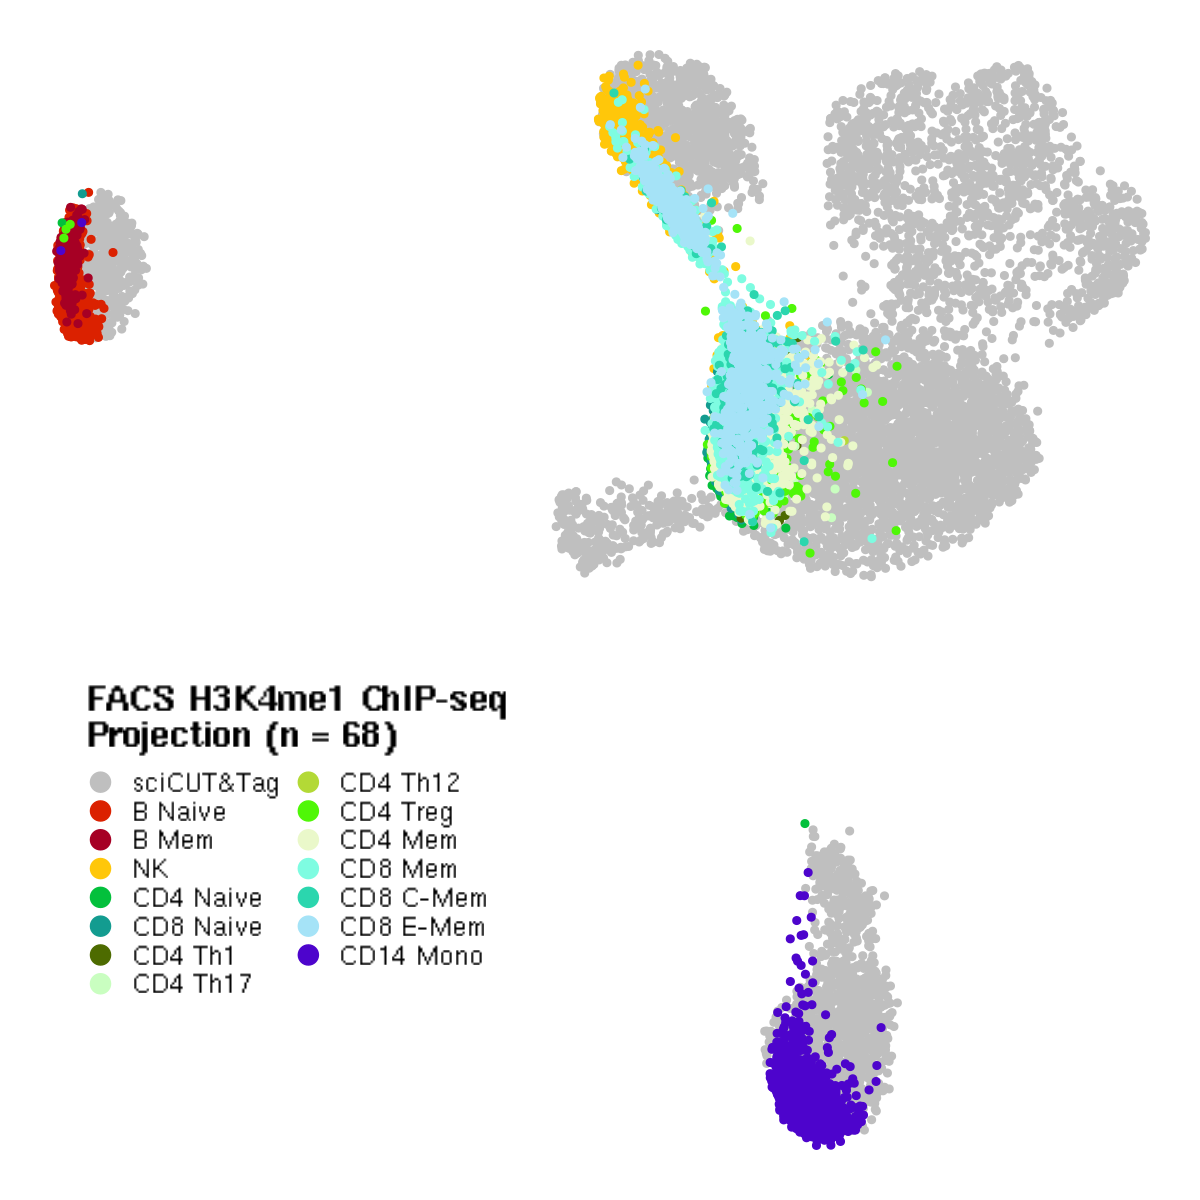

In [256]:
plot2 = ggplot(p, 
               aes(x=UMAP1, 
              y=UMAP2, 
              color = ds))+geom_point(position = "jitter"
    )+theme_void(
    )+theme(#plot.title = element_blank(), 
            #strip.text = element_blank(), 
            legend.position = c(.25, .30),
            legend.text = element_text(size=15, family = 'Helvetica'),
            legend.title = element_text(size=20, face = "bold", family = 'Helvetica')
    )+guides(color = guide_legend(override.aes = list(size = 5), ncol=2)
    )+scale_color_manual(name = "FACS H3K4me1 ChIP-seq \nProjection (n = 68)",
                         values = c("gray75",
                                    #B
                                    "#db2100", 
                                    "#a60024",
                                    #NK
                                    #"#ffd500",
                                    "#FFC70A",               
                                    #Naive T
                                    "#03C03C",
                                    "#139c90",
                                    #Treg
                                    '#4d6b00',
                                    '#c9fec0',
                                    "#B3D936",
                                    "#4ff707",
                                    #CD4 Mem
                                    '#EAF8CA',
                                    #'#ede6d6',
                                    #CD8 Mem
                                    '#7efce1',
                                    "#2bd6ae",
                                    '#A5E3F7',
                                    #'#75CFEE',
                                    #'#2270C4',
                                    #Mono
                                    #'#b23dd9',
                                    "#4d04cc"
                                    #"#db0bd4",
                                    #'#DDB6E3'
                                    #'#D4A994'
                                   )
)
plot2

In [257]:
#save
pdf(file=paste0(plot_dir, '221017_PBMC_K4me1_ENCODE_projection.pdf'),width=10, height=10)
plot2
dev.off()

png 
  2

In [186]:
a = subset(seCHIP, select = !(colData(seCHIP)$Biosample.term.name %in% c(


    'activated B cell',
    'activated CD4-positive, alpha-beta memory T cell',
    'activated CD4-positive, alpha-beta T cell',
    'activated CD8-positive, alpha-beta T cell',
    'activated naive CD4-positive, alpha-beta T cell',
    'activated naive CD8-positive, alpha-beta T cell',
    'activated T-cell',
    'activated T-helper 1 cell',
    'activated T-helper 17 cell',
    'activated T-helper 2 cell',
    
    'B cell',
    
    'CD4-positive, alpha-beta T cell',
    'CD8-positive, alpha-beta T cell',
    'dendritic cell',
     
    'IgD-negative memory B cell',
    'immature natural killer cell',
    
    'stimulated activated CD4-positive, alpha-beta memory T cell',
    'stimulated activated CD4-positive, alpha-beta T cell',
    'stimulated activated CD8-positive, alpha-beta memory T cell',
    'stimulated activated CD8-positive, alpha-beta T cell',
    'stimulated activated memory B cell',
    'stimulated activated naive B cell',
    'stimulated activated naive CD4-positive, alpha-beta T cell',
    'stimulated activated naive CD8-positive, alpha-beta T cell',
    'stimulated activated effector memory CD8-positive, alpha-beta T cell',
    
    'T-cell'

)))
a
saveRDS(a, "/fh/fast/henikoff_s/user/jgreene/projects/sciCnT/data/Encode_Blood_K4me123_ChIP_v2/H3K4me1_encode_blood_500_FINAL.RDS")

class: RangedSummarizedExperiment 
dim: 6176584 68 
metadata(0):
assays(1): counts
rownames: NULL
rowData names(0):
colnames(68): ENCFF796LSX.bam ENCFF834FYW.bam ... ENCFF195XYW.bam
  ENCFF115ZZA.bam
colData names(62): File.accession File.format ... paired depth

# H3K4me3 ChIP projection

In [190]:
#load ENCODE ChIP data
sum_dir = '/fh/fast/henikoff_s/user/jgreene/projects/sciCnT/data/Encode_Blood_K4me123_ChIP_v2/H3K4me123_encode_blood_500.RDS'
seCHIP = readRDS(sum_dir)
seCHIP

class: RangedSummarizedExperiment 
dim: 6176584 480 
metadata(0):
assays(1): counts
rownames: NULL
rowData names(0):
colnames(480): ENCFF722YKS.bam ENCFF796LSX.bam ... ENCFF241FBR.bam
  ENCFF115ZZA.bam
colData names(62): File.accession File.format ... paired depth

In [191]:
#remove unfiltered
table(colData(seCHIP)$Output.type)
seCHIP = subset(seCHIP, select = colData(seCHIP)$Output.type == 'alignments')
seCHIP


           alignments unfiltered alignments 
                  240                   240 

class: RangedSummarizedExperiment 
dim: 6176584 240 
metadata(0):
assays(1): counts
rownames: NULL
rowData names(0):
colnames(240): ENCFF796LSX.bam ENCFF932LFZ.bam ... ENCFF195XYW.bam
  ENCFF115ZZA.bam
colData names(62): File.accession File.format ... paired depth

In [192]:
#get only H3K4me3
table(colData(seCHIP)$Experiment.target)
seCHIP = subset(seCHIP, select = colData(seCHIP)$Experiment.target == 'H3K4me3-human')
seCHIP


H3K4me1-human H3K4me3-human 
          116           124 

class: RangedSummarizedExperiment 
dim: 6176584 124 
metadata(0):
assays(1): counts
rownames: NULL
rowData names(0):
colnames(124): ENCFF932LFZ.bam ENCFF329ZJR.bam ... ENCFF174WKX.bam
  ENCFF822FAZ.bam
colData names(62): File.accession File.format ... paired depth

In [215]:
table(colData(seCHIP)$Biosample.term.name)


                                                    activated B cell 
                                                                   2 
                    activated CD4-positive, alpha-beta memory T cell 
                                                                   1 
                           activated CD4-positive, alpha-beta T cell 
                                                                   2 
                           activated CD8-positive, alpha-beta T cell 
                                                                   1 
                     activated naive CD4-positive, alpha-beta T cell 
                                                                   2 
                     activated naive CD8-positive, alpha-beta T cell 
                                                                   3 
                                                    activated T-cell 
                                                                   7 
                   

In [225]:
projection<-projectBulkATAC(
  ArchRProj = proj,
  seATAC = seCHIP,
  reducedDims = "IterativeLSI",
  embedding = "UMAP",
  n = 500, 
  verbose = TRUE,
  threads = getArchRThreads(),
  logFile = createLogFile("projectBulkATAC")
)

ArchR logging to : ArchRLogs/ArchR-projectBulkATAC-350e3e2242e3-Date-2022-10-17_Time-10-56-54.log
If there is an issue, please report to github with logFile!

Overlap Ratio of Reduced Dims Features = 1

2022-10-17 10:57:08 : 

10:59:08 Creating temp directory /loc/scratch/66622569/Rtmpn1G7AY/dir350e6686951d

untar: using cmd = ‘/bin/tar -xf '/fh/fast/henikoff_s/user/jgreene/projects/sciCnT/data/ArchR/DJ_Hs_PBMC_K4me123_220523_220527_79x79_MERGE_50k/DJ_Hs_PBMC_K4me123_220523_220527_79x79_MERGE_50k/Embeddings/Save-Uwot-UMAP-Params-IterativeLSI-65e81d3fb2a3-Date-2022-10-16_Time-17-42-49.tar' -C '/loc/scratch/66622569/Rtmpn1G7AY/dir350e6686951d'’

10:59:10 Read 67000 rows
 and found 15 numeric columns

10:59:10 Processing block 1 of 1

10:59:10 Writing NN index file to temp file /loc/scratch/66622569/Rtmpn1G7AY/file350eb45ea57

10:59:10 Searching Annoy index using 11 threads, search_k = 4000

10:59:13 Commencing smooth kNN distance calibration using 11 threads
 with target n_neighbors = 40

In [226]:
meta = read.csv('/fh/fast/henikoff_s/user/jgreene/projects/sciCnT/data/Encode_Blood_K4me123_ChIP_v2/K4_meta_FINAL.csv')

p<-as.data.frame(do.call(rbind, projection[2:1]))
p$ds = data.frame(t(data.frame(strsplit(rownames(p), '#'))))$X1

In [227]:
unique(p$ds)

[1] "DJ_Hs_PBMC_K4me123_ALLSEQ_220523_220527"
  [2] "ENCFF932LFZ.bam"                        
  [3] "ENCFF329ZJR.bam"                        
  [4] "ENCFF111SLA.bam"                        
  [5] "ENCFF521HUG.bam"                        
  [6] "ENCFF723WQR.bam"                        
  [7] "ENCFF998OSA.bam"                        
  [8] "ENCFF950JDG.bam"                        
  [9] "ENCFF791EKQ.bam"                        
 [10] "ENCFF744HJM.bam"                        
 [11] "ENCFF145BCX.bam"                        
 [12] "ENCFF802OTQ.bam"                        
 [13] "ENCFF600ZLL.bam"                        
 [14] "ENCFF100AKU.bam"                        
 [15] "ENCFF493IBV.bam"                        
 [16] "ENCFF975QJB.bam"                        
 [17] "ENCFF624RND.bam"                        
 [18] "ENCFF933DBM.bam"                        
 [19] "ENCFF129ZOS.bam"                        
 [20] "ENCFF463TUH.bam"                        
 [21] "ENCFF793KQZ.bam"                        
 [22] "ENCFF333XEF.bam"                        
 [23] "ENCFF208JBN.bam"                        
 [24] "ENCFF689DCA.bam"                        
 [25] "ENCFF113ZIM.bam"                        
 [26] "ENCFF263VOV.bam"                        
 [27] "ENCFF498BJM.bam"                        
 [28] "ENCFF783YOJ.bam"                        
 [29] "ENCFF133MWE.bam"                        
 [30] "ENCFF693VHG.bam"                        
 [31] "ENCFF240QWN.bam"                        
 [32] "ENCFF442WOP.bam"                        
 [33] "ENCFF075FRV.bam"                        
 [34] "ENCFF486ZYM.bam"                        
 [35] "ENCFF346HDS.bam"                        
 [36] "ENCFF884DEC.bam"                        
 [37] "ENCFF537PIM.bam"                        
 [38] "ENCFF296ONT.bam"                        
 [39] "ENCFF284JPA.bam"                        
 [40] "ENCFF447HAA.bam"                        
 [41] "ENCFF970OAY.bam"                        
 [42] "ENCFF543REU.bam"                        
 [43] "ENCFF833VOD.bam"                        
 [44] "ENCFF074RMF.bam"                        
 [45] "ENCFF531ACD.bam"                        
 [46] "ENCFF621VDI.bam"                        
 [47] "ENCFF814NZT.bam"                        
 [48] "ENCFF182TKL.bam"                        
 [49] "ENCFF193ELT.bam"                        
 [50] "ENCFF143OOW.bam"                        
 [51] "ENCFF716HZE.bam"                        
 [52] "ENCFF090IEC.bam"                        
 [53] "ENCFF912WMS.bam"                        
 [54] "ENCFF136EFU.bam"                        
 [55] "ENCFF220GVE.bam"                        
 [56] "ENCFF314CTW.bam"                        
 [57] "ENCFF174DOB.bam"                        
 [58] "ENCFF612LPZ.bam"                        
 [59] "ENCFF622WUQ.bam"                        
 [60] "ENCFF621MTB.bam"                        
 [61] "ENCFF749ZDC.bam"                        
 [62] "ENCFF095JDW.bam"                        
 [63] "ENCFF842OUA.bam"                        
 [64] "ENCFF933DZK.bam"                        
 [65] "ENCFF605ZKD.bam"                        
 [66] "ENCFF527CXN.bam"                        
 [67] "ENCFF506CHM.bam"                        
 [68] "ENCFF694DLG.bam"                        
 [69] "ENCFF042KJH.bam"                        
 [70] "ENCFF873QGZ.bam"                        
 [71] "ENCFF824QTZ.bam"                        
 [72] "ENCFF484AEW.bam"                        
 [73] "ENCFF449DNF.bam"                        
 [74] "ENCFF099MYY.bam"                        
 [75] "ENCFF874QSA.bam"                        
 [76] "ENCFF270XVA.bam"                        
 [77] "ENCFF343XZB.bam"                        
 [78] "ENCFF093IFG.bam"                        
 [79] "ENCFF112NBD.bam"                        
 [80] "ENCFF586QOP.bam"                        
 [81] "ENCFF236MFV.bam"                        
 [82] "ENCFF348XZS.bam"                        
 [83] "ENCFF070HZE.bam"                        
 [84] "ENCFF206GCX

In [228]:
#map names to celltype
acc = meta$accession[which(meta$accession %in% p$ds)]
cel = meta$Biosample.term.name[which(meta$accession %in% p$ds)]
p$ds <- mapvalues(p$ds, from=acc, to=cel)
p = p[order(p$ds), ]

In [229]:
unique(p$ds)

[1] "activated B cell"                                                    
 [2] "activated CD4-positive, alpha-beta memory T cell"                    
 [3] "activated CD4-positive, alpha-beta T cell"                           
 [4] "activated CD8-positive, alpha-beta T cell"                           
 [5] "activated naive CD4-positive, alpha-beta T cell"                     
 [6] "activated naive CD8-positive, alpha-beta T cell"                     
 [7] "activated T-cell"                                                    
 [8] "activated T-helper 1 cell"                                           
 [9] "activated T-helper 17 cell"                                          
[10] "activated T-helper 2 cell"                                           
[11] "B cell"                                                              
[12] "CD14-positive monocyte"                                              
[13] "CD4-positive, alpha-beta memory T cell"                              
[14] "CD4-positive, alpha-beta T cell"                                     
[15] "CD4-positive, CD25-positive, alpha-beta regulatory T cell"           
[16] "CD8-positive, alpha-beta memory T cell"                              
[17] "CD8-positive, alpha-beta T cell"                                     
[18] "central memory CD8-positive, alpha-beta T cell"                      
[19] "dendritic cell"                                                      
[20] "DJ_Hs_PBMC_K4me123_ALLSEQ_220523_220527"                             
[21] "effector memory CD8-positive, alpha-beta T cell"                     
[22] "IgD-negative memory B cell"                                          
[23] "immature natural killer cell"                                        
[24] "memory B cell"                                                       
[25] "naive B cell"                                                        
[26] "naive thymus-derived CD4-positive, alpha-beta T cell"                
[27] "naive thymus-derived CD8-positive, alpha-beta T cell"                
[28] "natural killer cell"                                                 
[29] "stimulated activated CD4-positive, alpha-beta memory T cell"         
[30] "stimulated activated CD4-positive, alpha-beta T cell"                
[31] "stimulated activated CD8-positive, alpha-beta memory T cell"         
[32] "stimulated activated CD8-positive, alpha-beta T cell"                
[33] "stimulated activated effector memory CD8-positive, alpha-beta T cell"
[34] "stimulated activated memory B cell"                                  
[35] "stimulated activated naive B cell"                                   
[36] "stimulated activated naive CD4-positive, alpha-beta T cell"          
[37] "stimulated activated naive CD8-positive, alpha-beta T cell"          
[38] "T-cell"                                                              
[39] "T-helper 1 cell"                                                     
[40] "T-helper 17 cell"                                                    
[41] "T-helper 2 cell"

In [230]:
#rename celltypes
unq = unique(p$ds)
ann = c('B +Act',
        'CD4 Mem +Act',
        'CD4 +Act', 
        'CD8 +Act', 
        'CD4 Naive +Act', 
        'CD8 Naive +Act',
        'T +Act',
        'CD4 Th1 +Act',
        'CD4 Th17 +Act',
        'CD4 Th2 +Act',
        'B', 
        'CD14 Mono',
        'CD4 Mem', 
        'CD4 T',
        'CD4 Treg', 
        'CD8 Mem', 
        'CD8 T', 
        'CD8 C-Mem', 
        'DC',
        'sciCUT&Tag',
        'CD8 E-Mem', 
        'IgD- B Mem', 
        'NK Immature', 
        'B Mem', 
        'B Naive', 
        'CD4 Naive', 
        'CD8 Naive', 
        'NK', 
        'CD4 Mem +Stim',
        'CD4 T +Stim',
        'CD8 Mem +Stim',
        'CD8 T +Stim',
        'CD8 E-Mem +Stim',
        'B Mem +Stim', 
        'B Naive +Stim',
        'CD4 Naive +Stim',
        'CD8 Naive +Stim',
        'T', 
        'CD4 Th1',
        'CD4 Th17',
        'CD4 Th12'
        )

p$ds <- mapvalues(p$ds, from=unq, to=ann)

In [231]:
#reorder and plot
ord_new = c(
        'sciCUT&Tag',
    
        'B +Act',
    
        'CD4 Naive +Act', 
        'CD8 Naive +Act',
        
        'CD4 +Act', 
        'CD8 +Act', 
        'T +Act',
    
        'CD4 Mem +Act',
        'CD4 Th1 +Act',
        'CD4 Th17 +Act',
        'CD4 Th2 +Act',
    
        'B', 
        'B Naive',
        'B Mem', 
        'IgD- B Mem',
    
        'NK Immature', 
        'NK', 
    
        'CD4 Naive', 
        'CD8 Naive', 
        'T', 
        'CD4 T',
        'CD8 T', 
    
        'CD4 Th1',
        'CD4 Th17',
        'CD4 Th12',
        'CD4 Treg', 
    
        'CD4 Mem', 
        
        'CD8 Mem', 
        'CD8 C-Mem',
        'CD8 E-Mem', 
    
        'CD14 Mono',
    
        'DC',
    
        'B Naive +Stim',
        'B Mem +Stim', 
    
        'CD4 T +Stim',
        'CD8 T +Stim',
    
        'CD4 Naive +Stim',
        'CD8 Naive +Stim',
        'CD4 Mem +Stim',
        'CD8 Mem +Stim',
        'CD8 E-Mem +Stim'
        )

p$ds <- factor(p$ds, levels = ord_new)
p <- p[order(p$ds),]

In [232]:
#drop stim and non specific data
p<-p[!(p$ds %in% c(             
        'B +Act',
    
        'CD4 Naive +Act', 
        'CD8 Naive +Act',
        
        'CD4 +Act', 
        'CD8 +Act', 
        'T +Act',
    
        'CD4 Mem +Act',
        'CD4 Th1 +Act',
        'CD4 Th17 +Act',
        'CD4 Th2 +Act',
    
        'B', 
        'IgD- B Mem',
    
        'NK Immature',  
        'T', 
        'CD4 T',
        'CD8 T', 
        'DC',
    
        'B Naive +Stim',
        'B Mem +Stim', 
    
        'CD4 T +Stim',
        'CD8 T +Stim',
    
        'CD4 Naive +Stim',
        'CD8 Naive +Stim',
        'CD4 Mem +Stim',
        'CD8 Mem +Stim',
        'CD8 E-Mem +Stim'
)),]

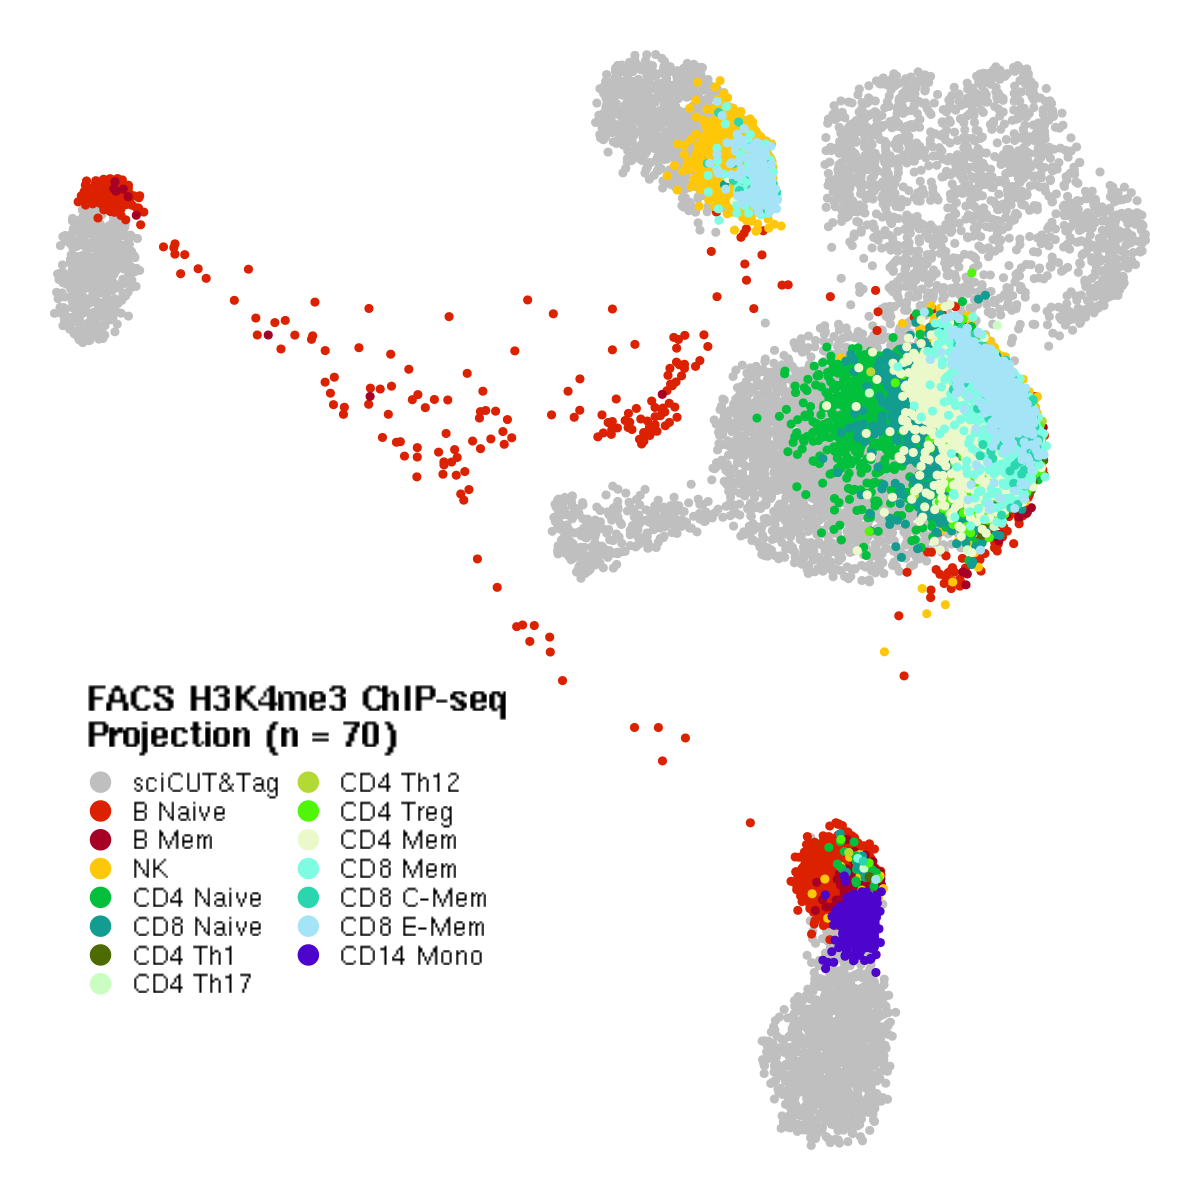

In [240]:
plot2 = ggplot(p, 
               aes(x=UMAP1, 
              y=UMAP2, 
              color = ds))+geom_point(position = "jitter"
    )+theme_void(
    )+theme(#plot.title = element_blank(), 
            #strip.text = element_blank(), 
            legend.position = c(.25, .30),
            legend.text = element_text(size=15, family = 'Helvetica'),
            legend.title = element_text(size=20, face = "bold", family = 'Helvetica')
    )+guides(color = guide_legend(override.aes = list(size = 5), ncol=2)
    )+scale_color_manual(name = "FACS H3K4me3 ChIP-seq \nProjection (n = 70)",
                         values = c("gray75",
                                    #B
                                    "#db2100", 
                                    "#a60024",
                                    #NK
                                    #"#ffd500",
                                    "#FFC70A",               
                                    #Naive T
                                    "#03C03C",
                                    "#139c90",
                                    #Treg
                                    '#4d6b00',
                                    '#c9fec0',
                                    "#B3D936",
                                    "#4ff707",
                                    #CD4 Mem
                                    '#EAF8CA',
                                    #'#ede6d6',
                                    #CD8 Mem
                                    '#7efce1',
                                    "#2bd6ae",
                                    '#A5E3F7',
                                    #'#75CFEE',
                                    #'#2270C4',
                                    #Mono
                                    #'#b23dd9',
                                    "#4d04cc"
                                    #"#db0bd4",
                                    #'#DDB6E3'
                                    #'#D4A994'
                                   )
)
plot2

In [241]:
#save
pdf(file=paste0(plot_dir, '221017_PBMC_K4me3_ENCODE_projection.pdf'),width=10, height=10)
plot2
dev.off()

png 
  2

In [202]:
a = subset(seCHIP, select = !(colData(seCHIP)$Biosample.term.name %in% c(


    'activated B cell',
    'activated CD4-positive, alpha-beta memory T cell',
    'activated CD4-positive, alpha-beta T cell',
    'activated CD8-positive, alpha-beta T cell',
    'activated naive CD4-positive, alpha-beta T cell',
    'activated naive CD8-positive, alpha-beta T cell',
    'activated T-cell',
    'activated T-helper 1 cell',
    'activated T-helper 17 cell',
    'activated T-helper 2 cell',
    
    'B cell',
    
    'CD4-positive, alpha-beta T cell',
    'CD8-positive, alpha-beta T cell',
    'dendritic cell',
     
    'IgD-negative memory B cell',
    'immature natural killer cell',
    
    'stimulated activated CD4-positive, alpha-beta memory T cell',
    'stimulated activated CD4-positive, alpha-beta T cell',
    'stimulated activated CD8-positive, alpha-beta memory T cell',
    'stimulated activated CD8-positive, alpha-beta T cell',
    'stimulated activated memory B cell',
    'stimulated activated naive B cell',
    'stimulated activated naive CD4-positive, alpha-beta T cell',
    'stimulated activated naive CD8-positive, alpha-beta T cell',
    'stimulated activated effector memory CD8-positive, alpha-beta T cell',
    
    'T-cell'

)))
a
saveRDS(a, "/fh/fast/henikoff_s/user/jgreene/projects/sciCnT/data/Encode_Blood_K4me123_ChIP_v2/H3K4me3_encode_blood_500_FINAL.RDS")

class: RangedSummarizedExperiment 
dim: 6176584 70 
metadata(0):
assays(1): counts
rownames: NULL
rowData names(0):
colnames(70): ENCFF521HUG.bam ENCFF723WQR.bam ... ENCFF174WKX.bam
  ENCFF822FAZ.bam
colData names(62): File.accession File.format ... paired depth